In [1]:

import matplotlib.pyplot as plt
import mglearn
import np as np
import numpy as np
import pandas as pd
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVC

!pip install numpy scipy scikit-learn matplotlib pandas
from sklearn.model_selection import GridSearchCV

You should consider upgrading via the '/Users/engineer/workspace/cse590-machine-learning/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
X = pd.read_csv("../dataset/extracted_features.csv").values
index_for_removal = np.array(
    [
        0, 10, 14, 17, 25, 26, 35, 39, 49, 59, 62,
    ]
)
X_indexed = np.delete(X, index_for_removal, 1)

y = pd.read_csv("../dataset/labels.csv").values
# images = pd.read_csv("../dataset/raw_images.csv").values
X_train, X_test, y_train, y_test = train_test_split(X_indexed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
y_train = y_train.ravel()

select = SelectPercentile(percentile=90)
select.fit(X_train, y_train)
X_train = select.transform(X_train)
X_test = select.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=200,
    max_features=3,
).fit(X_train, y_train)

select_sfm = SelectFromModel(
    rf,
    threshold='0.1*mean',
)
select_sfm.fit(X_train, y_train)
X_train = select_sfm.transform(X_train)
X_test = select_sfm.transform(X_test)


select_rfe = RFE(RandomForestClassifier(
    n_estimators=200, random_state=42
), n_features_to_select=40)

select_rfe.fit(X_train, y_train)
X_train = select_rfe.transform(X_train)
X_test = select_rfe.transform(X_test)

scaler_standard = StandardScaler().fit(X_train)
X_train_standard = scaler_standard.transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

scaler_robust = RobustScaler().fit(X)
X_robust = scaler_robust.transform(X)

scaler_minmax = MinMaxScaler().fit(X)
X_minmax = scaler_minmax.transform(X)


In [3]:
def shape_params_linear_kernel(c_values):
    hyper_params = dict(C=c_values)
    return hyper_params


def shape_params_polynomial_kernel(c_values, d_values):
    hyper_params = shape_params_linear_kernel(c_values)
    hyper_params['degree'] = d_values
    return hyper_params


def shape_params_radial_kernel(c_values, gamma_values):
    hyper_params = shape_params_linear_kernel(c_values)
    hyper_params['gamma'] = gamma_values
    return hyper_params


def run_grid_svm(kernel, hyper_parameters, X_data):
    classifier = SVC(
        kernel=kernel,
        random_state=0
    )
    grid_search = GridSearchCV(
        classifier,
        hyper_parameters,
        cv=4,
        return_train_score=True
    )
    grid_search.fit(X_data, y_train)

    print_grid_search_results(grid_search, hyper_parameters)
    return grid_search


def print_grid_search_results(grid_search, parameters):
    for parameter in parameters:
        print(f'Best {parameter}:', grid_search.best_params_[parameter])
    print("Train score: ", grid_search.cv_results_['mean_train_score'])
    print("Test score: ", grid_search.cv_results_['mean_test_score'])


def preprocess_data(X_scaled):
    pca = PCA(n_components=2)
    pca.fit(X_scaled)

    return pca.fit_transform(X_scaled)


def display_preprocessed_2d(pca_data):
    plt.figure(figsize=(32, 32))
    mglearn.discrete_scatter(pca_data[:, 0], pca_data[:, 1], y_train)
    plt.legend(
        [
            '0: T-shirt/top',
            '1: Trouser',
            '2: Pullover',
            '3: Dress',
            '4: Coat,',
        ],
        loc="best"
    )
    plt.gca().set_aspect("equal")
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")


def scale(scaler, X_data):
    return scaler.fit(X_data).transform(X_data)


In [4]:
for i in range(9):
    print(np.count_nonzero(y==i))

325
99
133
154
281
283
325
318
301


In [5]:
cov_mat = np.cov(X_train_standard)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key = lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:,np.newaxis], eigen_pairs[1][1][:,np.newaxis]))
# X_train_pca = X_standard.dot(w)


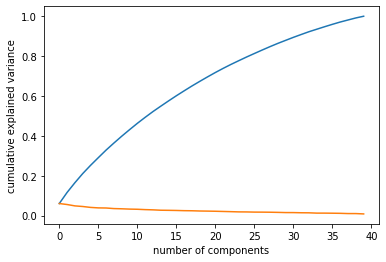

In [6]:
pca = PCA().fit(X_train_standard)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [7]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.0605972  0.11623431 0.16502109 0.2107379  0.25190803 0.29065938
 0.32881468 0.36409267 0.39828703 0.4309538  0.4627842  0.49286689
 0.52178408 0.54880629 0.57532551 0.60116393 0.62593659 0.65024576
 0.67338676 0.69594937 0.71781571 0.73863046 0.75844385 0.77713268
 0.79556609 0.81315455 0.83057122 0.84756215 0.86380831 0.87906451
 0.89420522 0.9085085  0.92249121 0.93499366 0.9474716  0.95952175
 0.97102391 0.98128532 0.99149458 1.        ]


56 features = 100
36 = .807

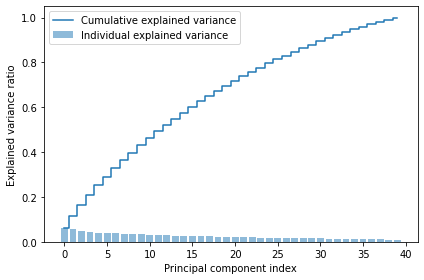

In [8]:
#
# Scale the dataset; This is very important before you apply PCA
#
from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)
#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_standard)

#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Second principal component')

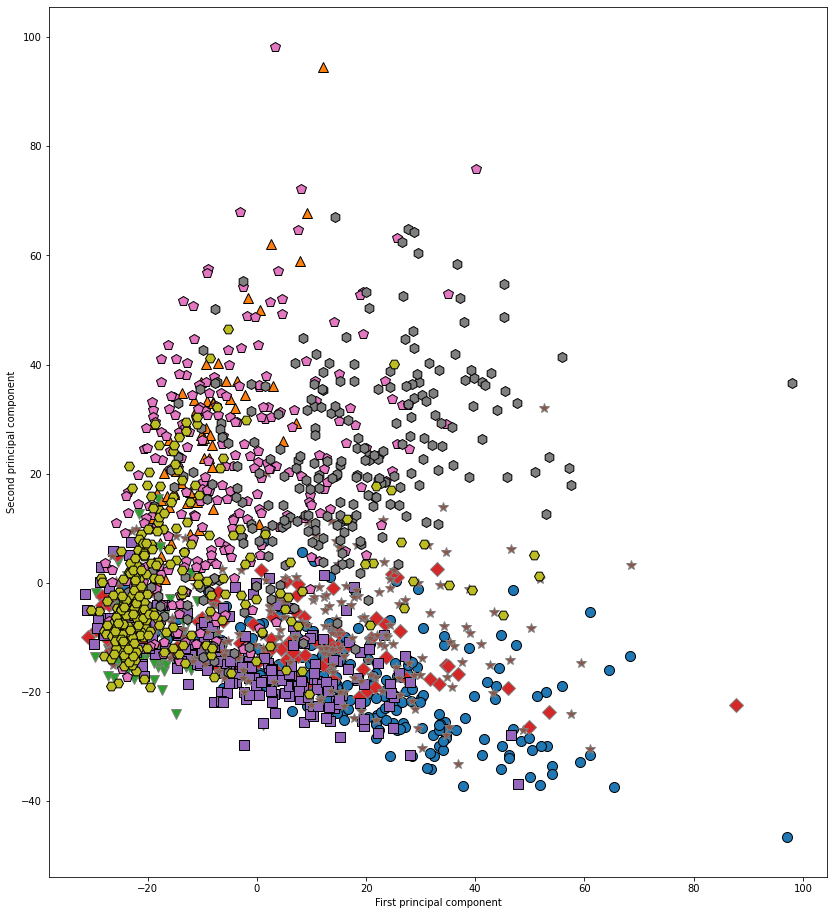

In [9]:
from sklearn.decomposition import PCA

pca_standard = PCA(n_components=2)
pca_standard.fit(X_train)

X_train_pca_scaler = pca_standard.fit_transform(X_train)

# 0: T-shirt/top
# 1: Trouser
# 2: Pullover
# 3: Dress
# 4: Coat
plt.figure(figsize=(16, 16))
mglearn.discrete_scatter(X_train_pca_scaler[:, 0], X_train_pca_scaler[:, 1], y_train)
# plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

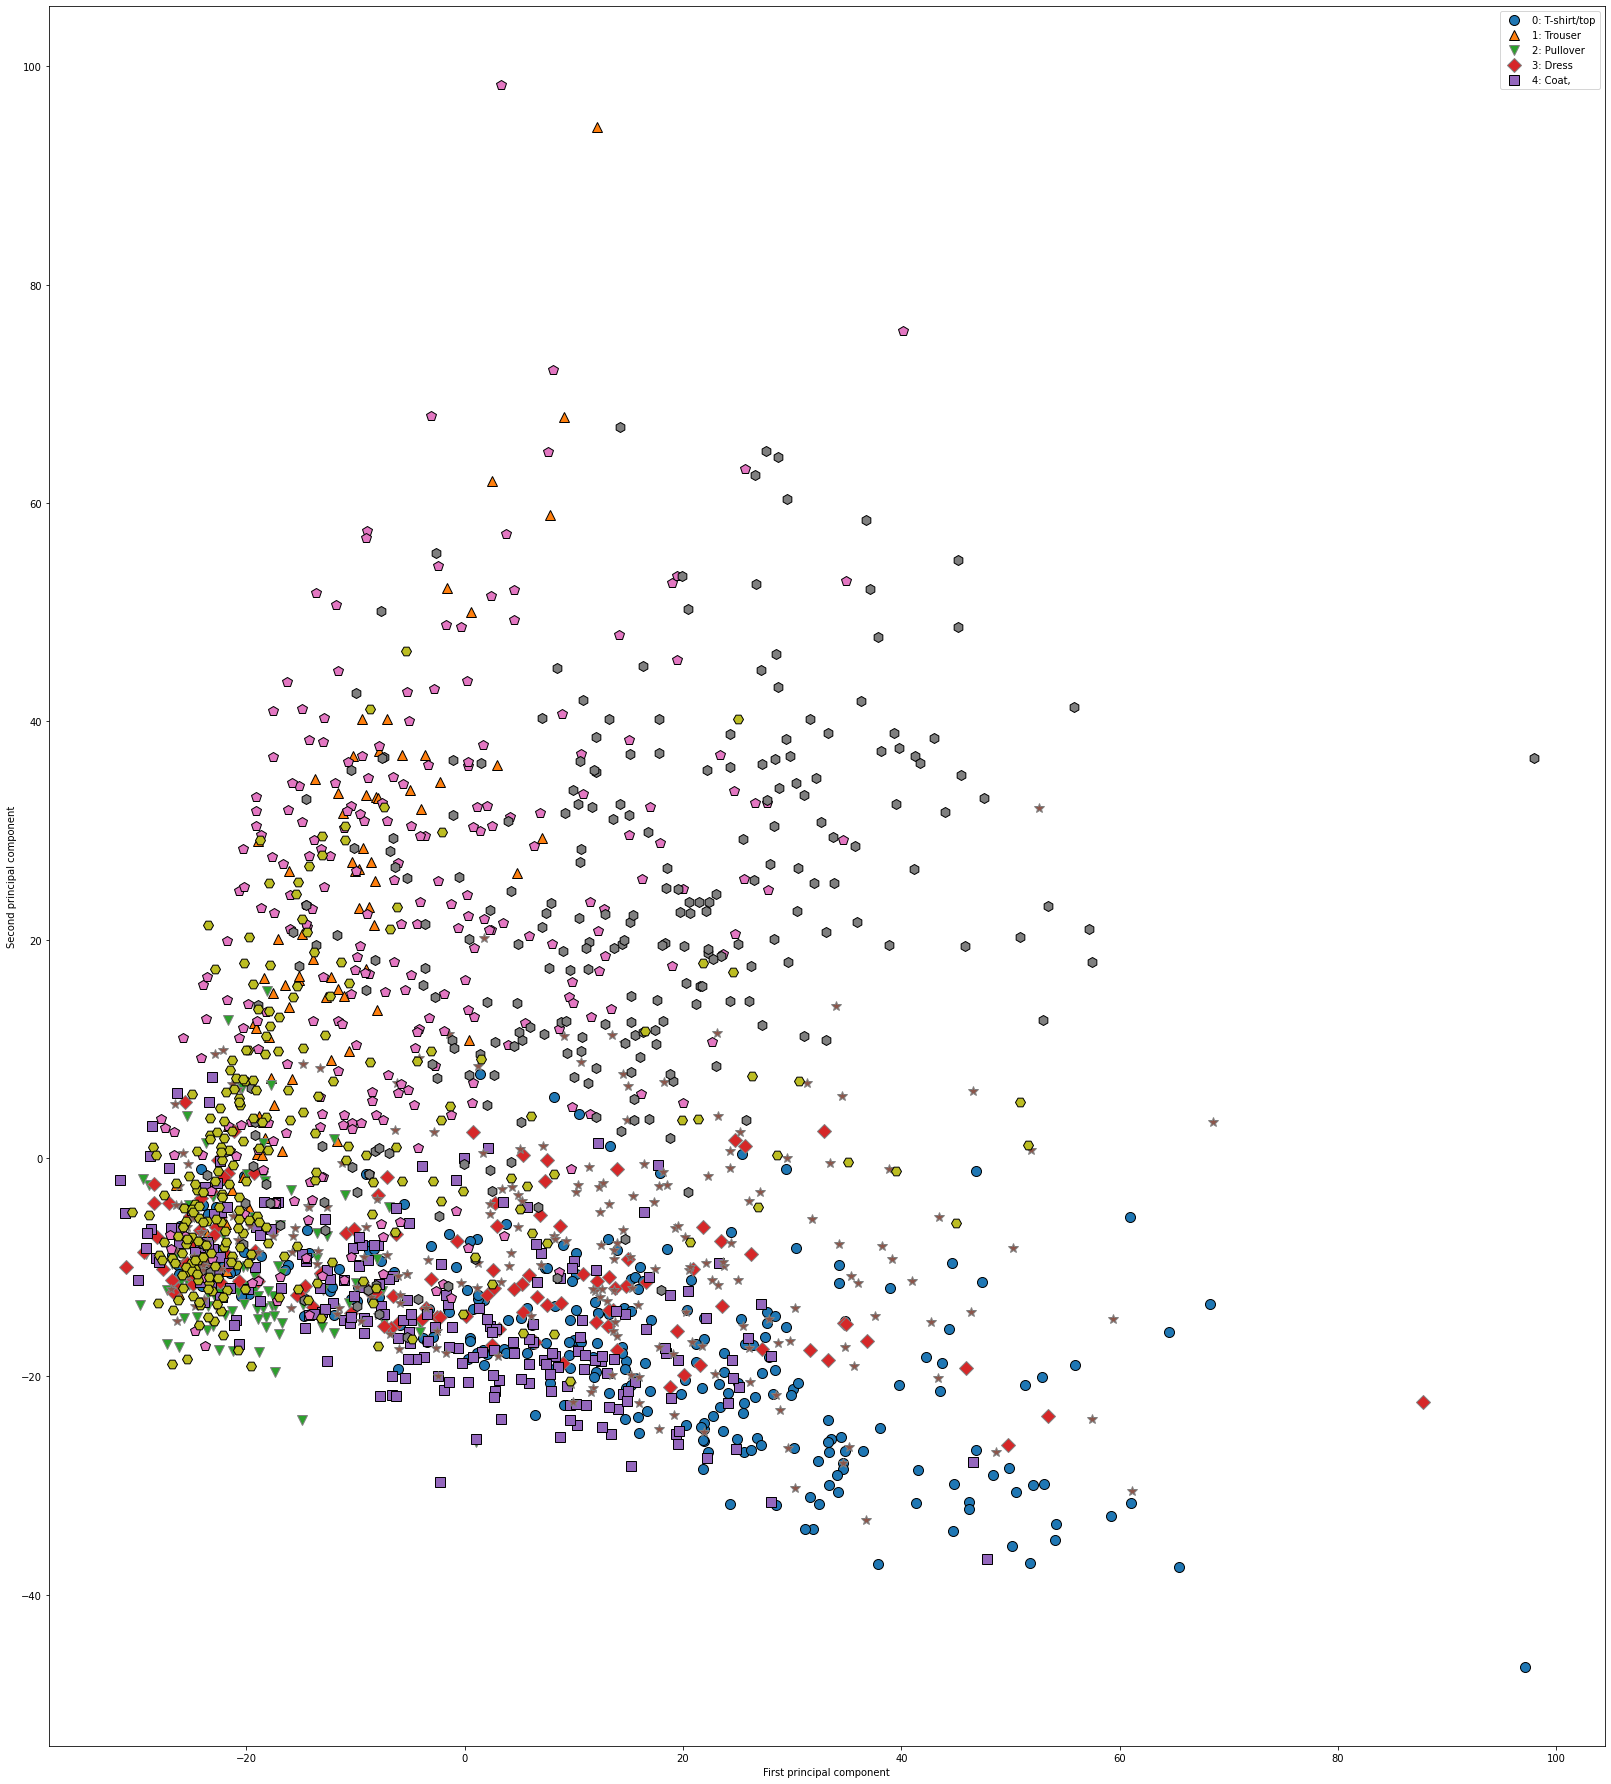

In [10]:

pca_vanilla = PCA(n_components=2).fit_transform(X_train)
display_preprocessed_2d(pca_vanilla)

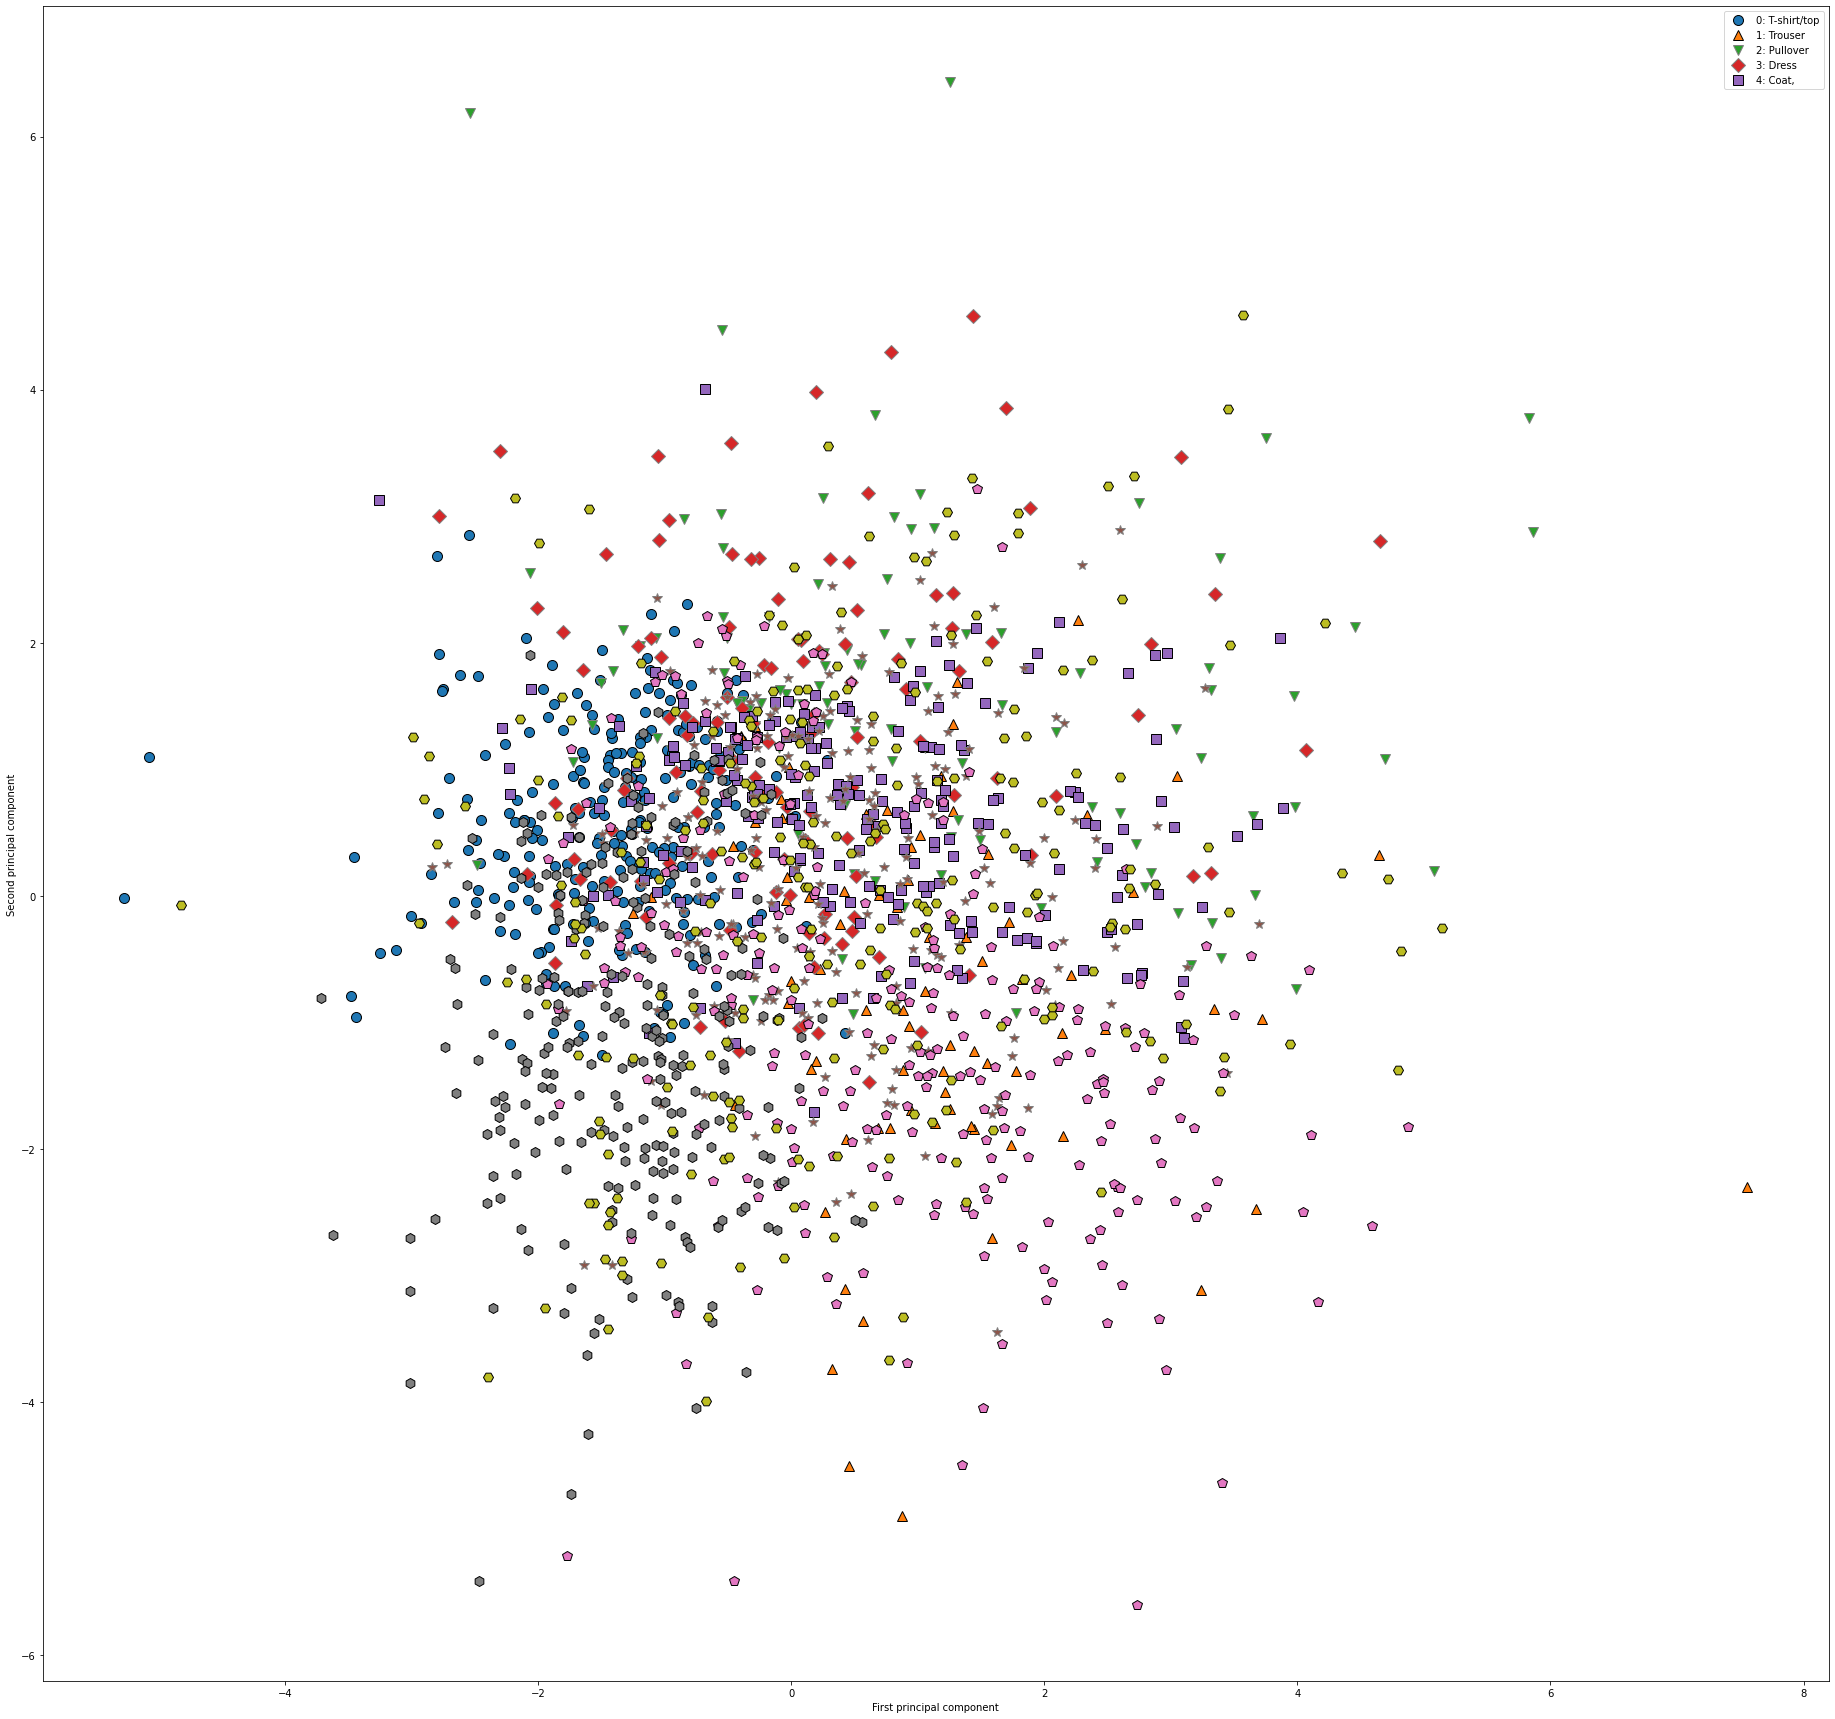

In [33]:
X_pca_standard = preprocess_data(
    scale(StandardScaler(), X_train)
)
display_preprocessed_2d(X_pca_standard)


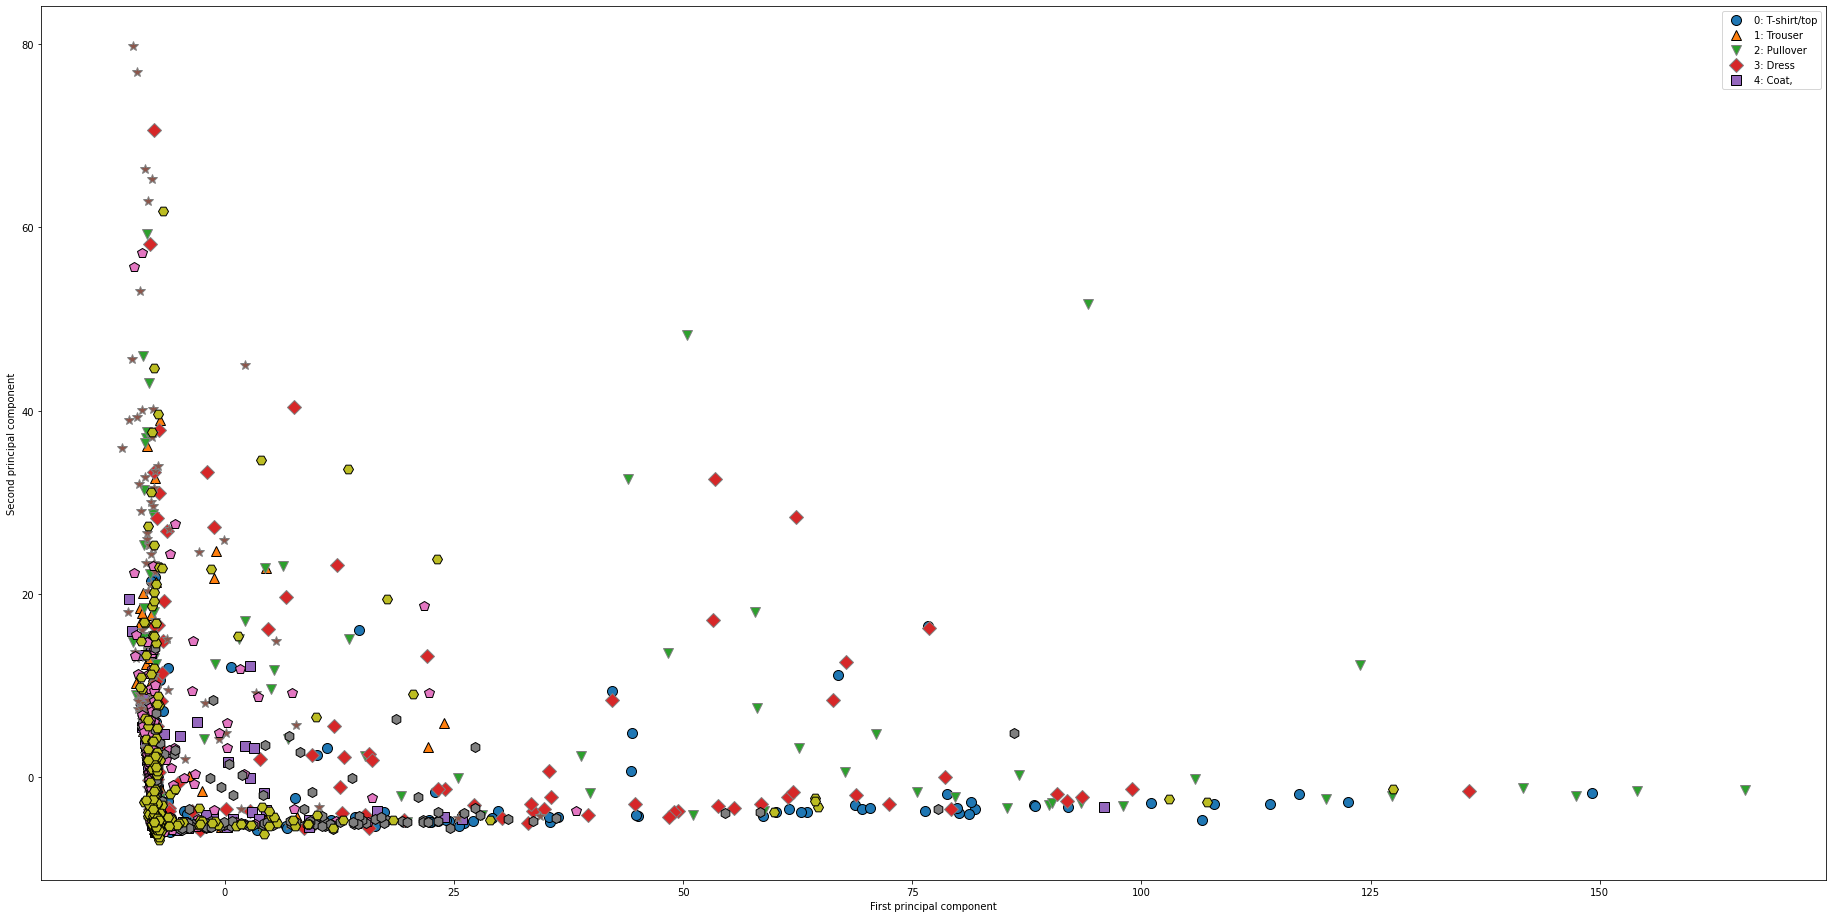

In [34]:
X_pca_standard = preprocess_data(
    scale(RobustScaler(), X_train)
)
display_preprocessed_2d(X_pca_standard)

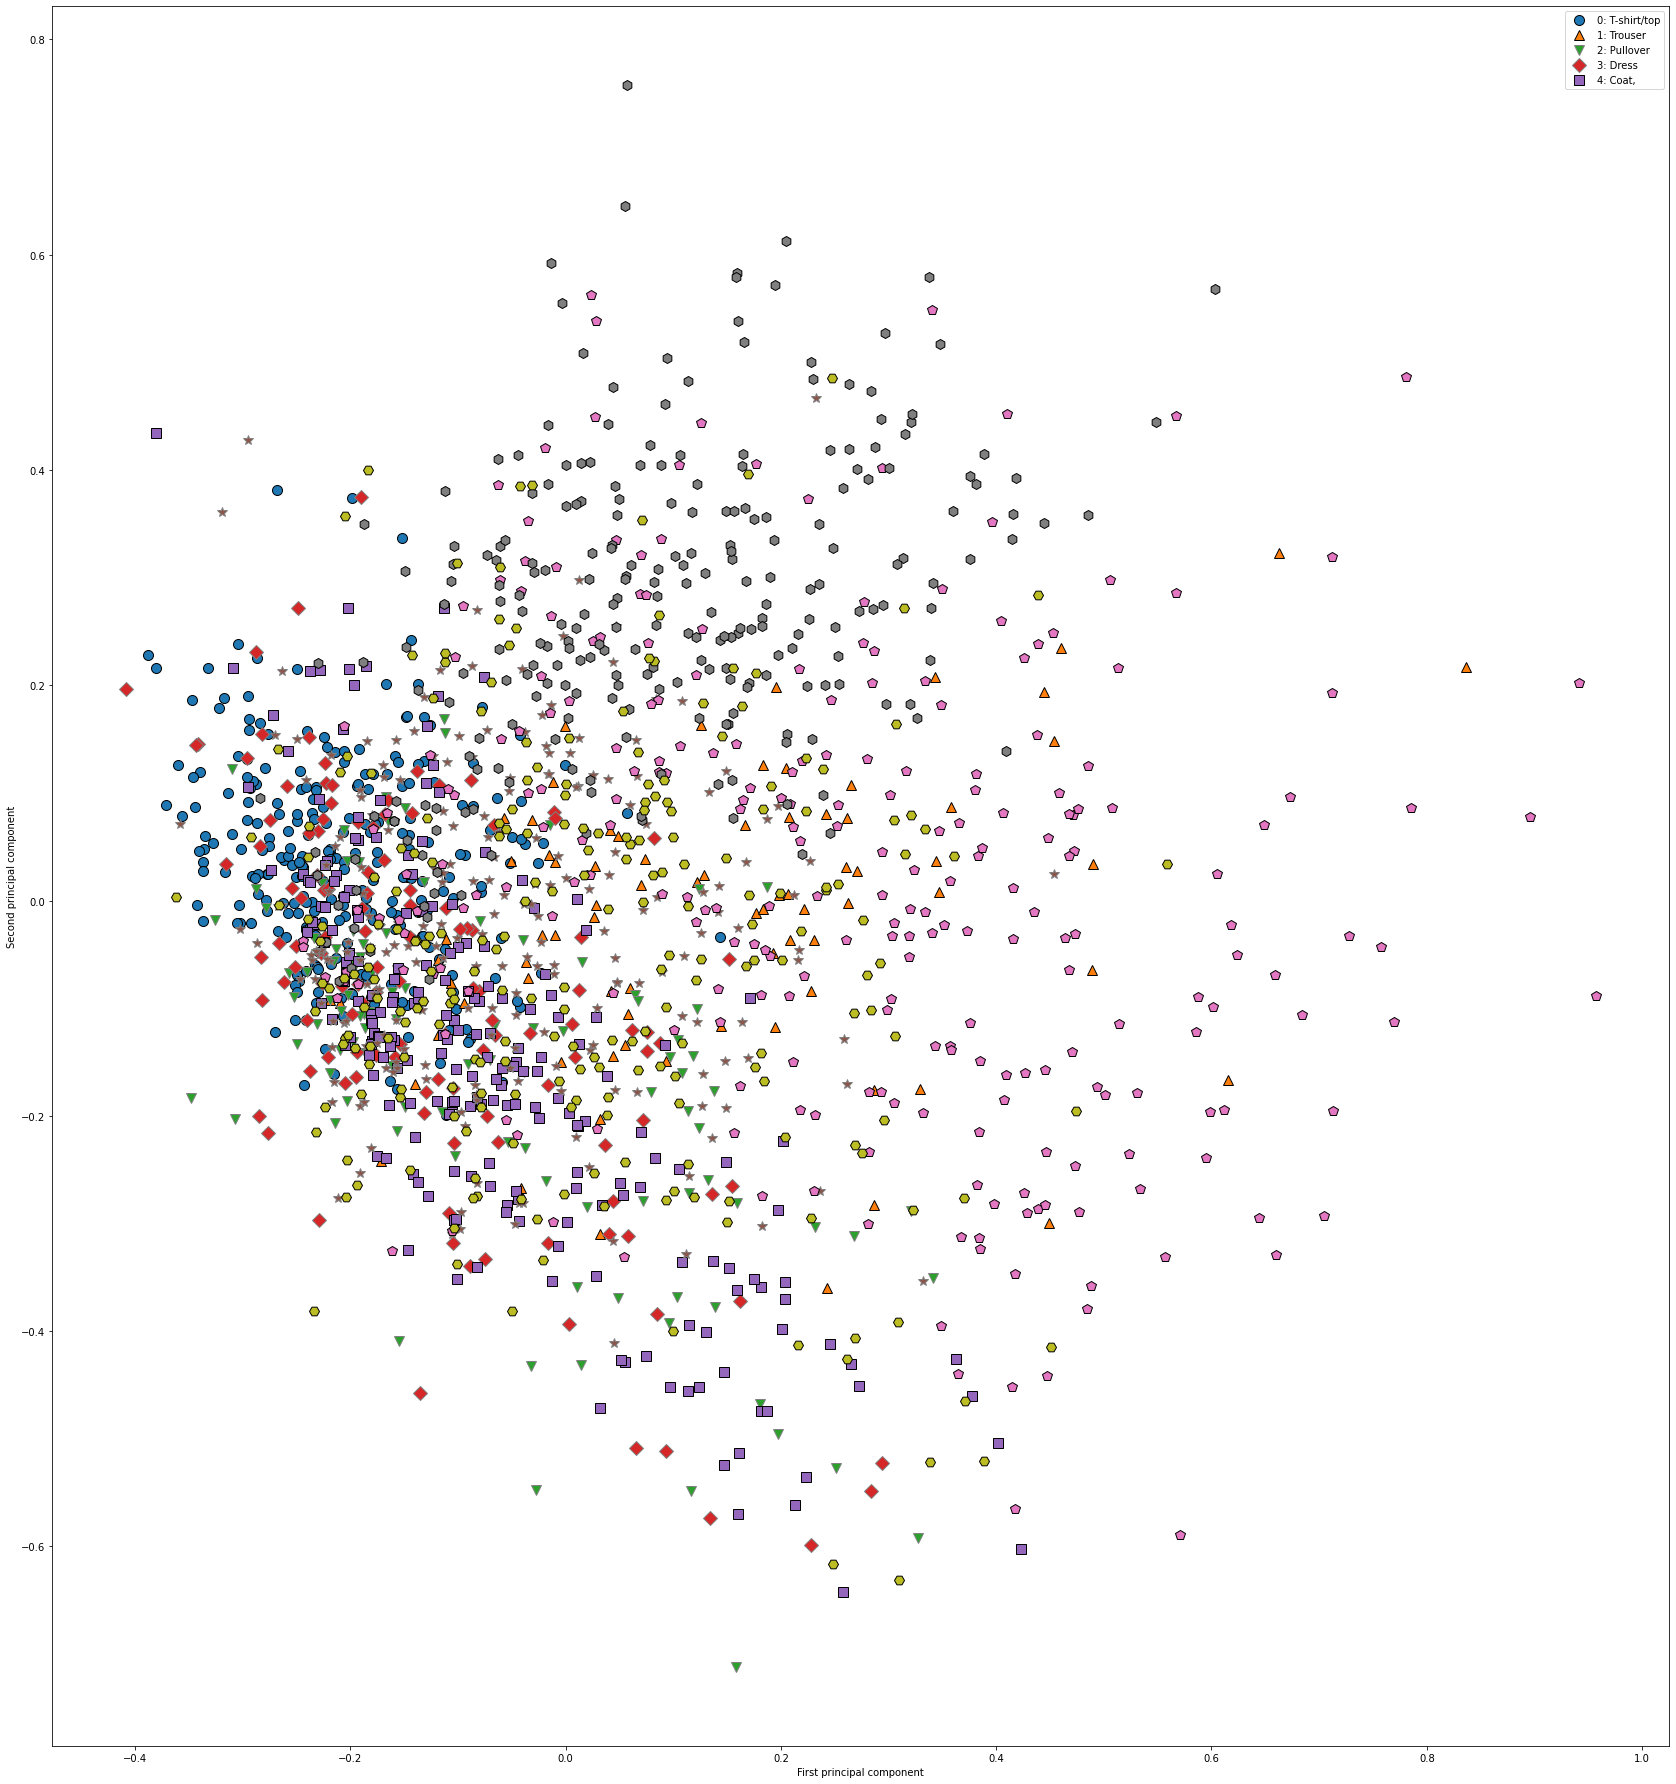

In [38]:
X_pca_minmax = preprocess_data(
    scale(MinMaxScaler(), X_train)
)
display_preprocessed_2d(X_pca_minmax)